In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import logging
import os
from keras_tuner import Hyperband
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
# Import from scripts
sys.path.append("..")
from src.data_loader import load_tsla_data
from scripts.lstm import preprocess_data, build_lstm_model,train_lstm, forecast_lstm,evaluate_lstm, plot_lstm_results,tune_hyperparameters



In [7]:
data = load_tsla_data('data/TSLA_cleaned.csv')



In [8]:
print("Initial NaNs:", data.isna().sum())

Initial NaNs: Price           0
Close           0
High            0
Low             0
Volume          0
Daily_Return    0
Rolling_Mean    0
Rolling_Std     0
Z_Score         0
dtype: int64


In [9]:

data.head()

,Price,Close,High,Low,Volume,Daily_Return,Rolling_Mean,Rolling_Std,Z_Score
Date,,,,,,,,,
2015-02-17,13.623333,13.713333,13.433333,13.713333,59694000,-0.140787,13.940933,0.583636,-0.895868
2015-02-18,13.630667,13.744667,13.506667,13.611333,40704000,0.228492,13.917978,0.577107,-0.895605
2015-02-19,14.114000,14.162667,13.583333,13.666667,77311500,3.041181,13.914067,0.574963,-0.892099
2015-02-20,14.474000,14.506667,13.987333,14.052000,89731500,2.428920,13.920333,0.580523,-0.889213
2015-02-23,13.822667,14.546667,13.755333,14.377333,127497000,0.275735,13.930111,0.588737,-0.888878


In [10]:
# Preprocess
X_train, y_train, X_test, y_test, scaler = preprocess_data(data, look_back=60)


In [11]:
# Build model
model = build_lstm_model(input_shape=(X_train.shape[1], 1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# Train
trained_model, history = train_lstm(model, X_train, y_train)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0249 - val_loss: 0.0276 - learning_rate: 0.0010
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0221 - val_loss: 0.0271 - learning_rate: 0.0010
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0207 - val_loss: 0.0269 - learning_rate: 0.0010
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0243 - val_loss: 0.0272 - learning_rate: 0.0010
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0220 - val_loss: 0.0269 - learning_rate: 0.0010
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0220 - val_loss: 0.0272 - learning_rate: 0.0010
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0222 - val_loss: 0.0270 - learning_rate: 0.0010
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0220 - val_loss: 0.0271 - learning_rate: 0.0010
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0225 - val_loss: 0.0269 - learning_rate: 2.0000e-04
Epoch 10/

In [13]:
# Forecast
predictions = forecast_lstm(trained_model, X_test, scaler, data)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Scaled predictions sample: [[-0.11515815]
 [-0.11122176]
 [-0.1108868 ]
 [-0.10931937]
 [-0.10919621]]
Inverse transformed sample: [[-0.00052336]
 [ 0.00029951]
 [ 0.00036953]
 [ 0.00069719]
 [ 0.00072294]]
Index range: 2044 to 2504
Last prices sample: [197.33000183 207.78999329 202.69000244 198.74000549 190.67999268]
Final prices sample: [197.2267216  207.85221678 202.76490629 198.87855429 190.81783241]


In [14]:
# Align predictions
valid = data.iloc[-len(predictions):].copy()
valid['Predictions'] = predictions

MAE: 5.60
RMSE: 8.20
MAPE: 2.27%


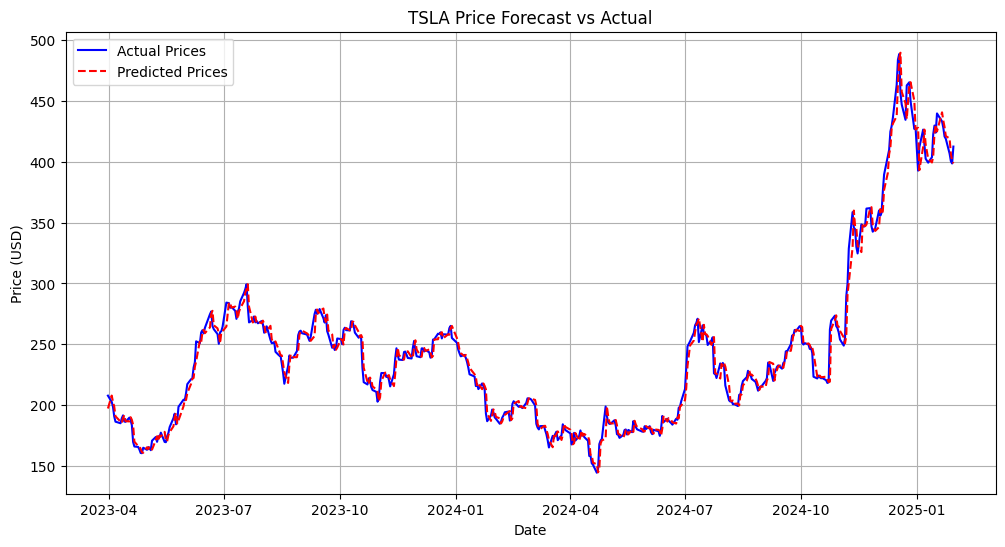

In [15]:
# Evaluate
evaluate_lstm(valid['Close'], valid['Predictions'])
plot_lstm_results(valid['Close'], valid['Predictions'], valid.index)

In [16]:
#Run hyperparameter tuning
best_model = tune_hyperparameters(X_train, y_train)

# 5. Train the best model with full training data
print("\nTraining optimized model...")
history = best_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    verbose=1,
    callbacks=[EarlyStopping(monitor='loss', patience=10)]
)

Trial 30 Complete [00h 00m 10s]
val_loss: 0.02683788537979126

Best val_loss So Far: 0.02678987942636013
Total elapsed time: 00h 02m 45s

Training optimized model...
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0237
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0259
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0263
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0252
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0242
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0240
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0241
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0234
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0222
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0248
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0243
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0224
Epoch 13/100
16/16 ━━━━━━━━


Evaluating optimized model:
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Scaled predictions sample: [[-0.12048125]
 [-0.10138753]
 [-0.12385864]
 [-0.10878719]
 [-0.11679736]]
Inverse transformed sample: [[-0.00163612]
 [ 0.00235529]
 [-0.00234213]
 [ 0.00080844]
 [-0.00086603]]
Index range: 2044 to 2504
Last prices sample: [197.33000183 207.78999329 202.69000244 198.74000549 190.67999268]
Final prices sample: [197.0071526  208.27940878 202.21528119 198.9006823  190.51486459]
MAE: 5.69
RMSE: 8.40
MAPE: 2.31%


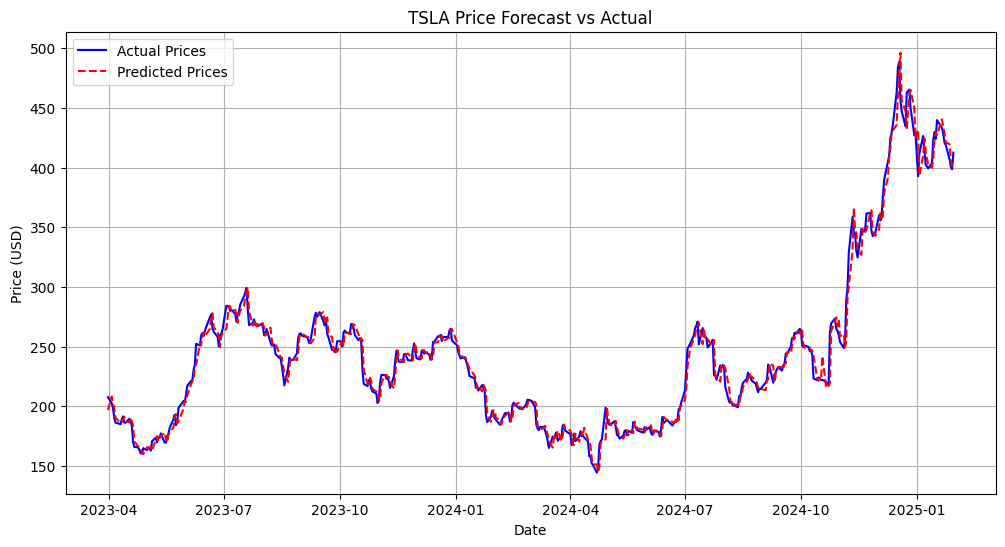

In [17]:
# 6. Evaluate optimized model
print("\nEvaluating optimized model:")
predicted_prices = forecast_lstm(best_model, X_test, scaler, data)
actual_prices = data['Close'].iloc[-len(predicted_prices):].values

mae, rmse, mape = evaluate_lstm(actual_prices, predicted_prices)
plot_lstm_results(actual_prices, predicted_prices, data.index[-len(predicted_prices):])

In [18]:
# 7. Compare with baseline
print("\nBaseline model comparison:")
original_model = build_lstm_model((X_train.shape[1], 1))
original_model.fit(X_train, y_train, epochs=50, verbose=0)
base_preds = forecast_lstm(original_model, X_test, scaler, data)
evaluate_lstm(actual_prices, base_preds)


Baseline model comparison:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Scaled predictions sample: [[-0.11623553]
 [-0.10043515]
 [-0.11936083]
 [-0.10694478]
 [-0.11758544]]
Inverse transformed sample: [[-0.00074858]
 [ 0.00255437]
 [-0.0014019 ]
 [ 0.00119358]
 [-0.00103077]]
Index range: 2044 to 2504
Last prices sample: [197.33000183 207.78999329 202.69000244 198.74000549 190.67999268]
Final prices sample: [197.18228558 208.32077551 202.40585107 198.97720634 190.48345058]
MAE: 5.73
RMSE: 8.52
MAPE: 2.32%


(5.725951942979078, 8.520693086141417, 2.318383086449115)

In [20]:
# Save model (new .keras format)
best_model.save('optimized_lstm.keras')

# Load model
loaded_model = tf.keras.models.load_model('optimized_lstm.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
